In [77]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
from sklearn.decomposition import FastICA

import warnings
warnings.filterwarnings('ignore')

In [94]:
filename = '../SampleWavFiles/stereo.wav'

# Load the audio file
audio, sr = librosa.load(filename, mono=False)
num_sources = 2

print('Audio Shape:', audio.shape)
print('Sample Rate:', sr)

Audio Shape: (4, 150912)
Sample Rate: 22050


In [95]:
ipd.Audio(audio, rate=sr)

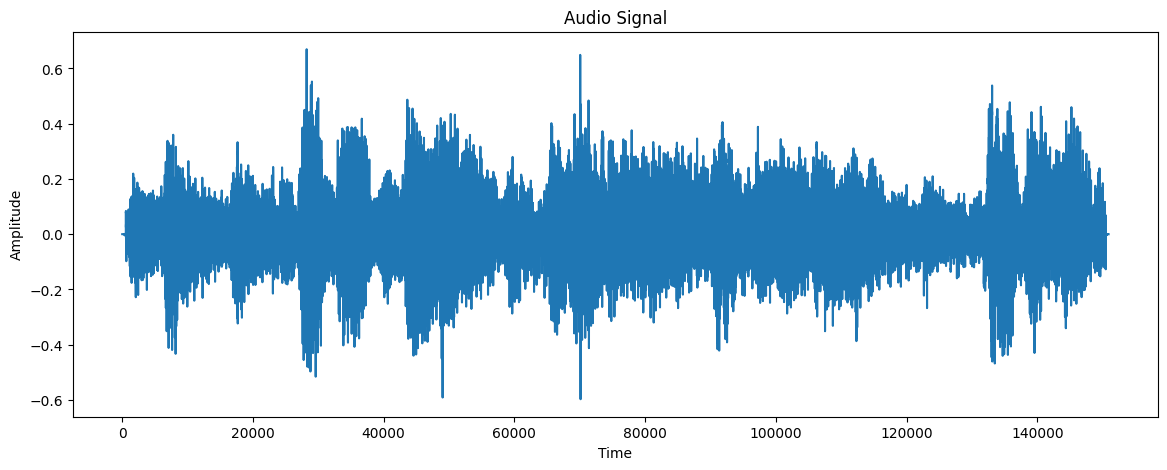

In [96]:
# Plot the audio
plotting_audio = np.sum(audio, axis=0)

plt.figure(figsize=(14, 5))
plt.plot(plotting_audio)
plt.title('Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

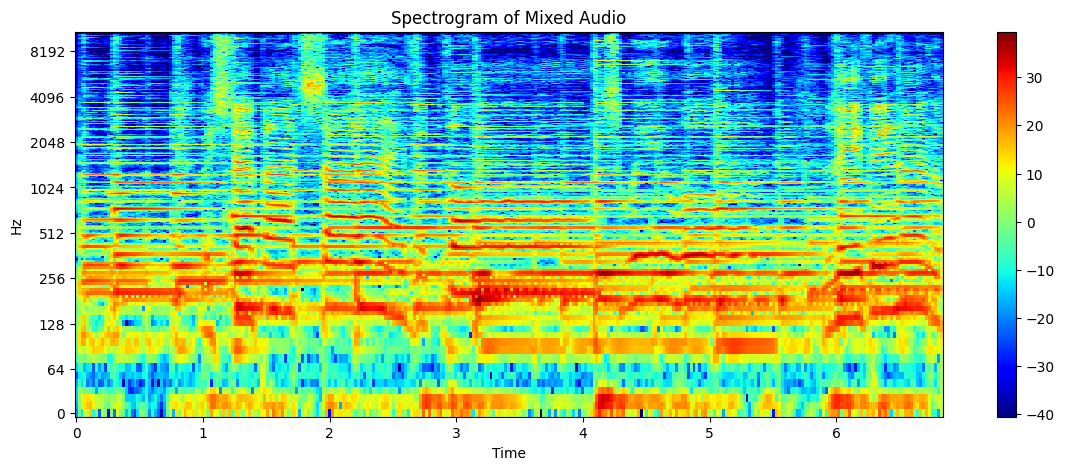

In [97]:
# Plot the audio file spectrogram
X = librosa.stft(plotting_audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log', cmap=matplotlib.cm.jet)
plt.title('Spectrogram of Mixed Audio')
plt.colorbar()
plt.show()

In [98]:
ica = FastICA(n_components=num_sources)

In [99]:
ica_output = ica.fit_transform(audio.T)

In [100]:
print('ICA Output Shape:', ica_output.shape)

ICA Output Shape: (150912, 2)


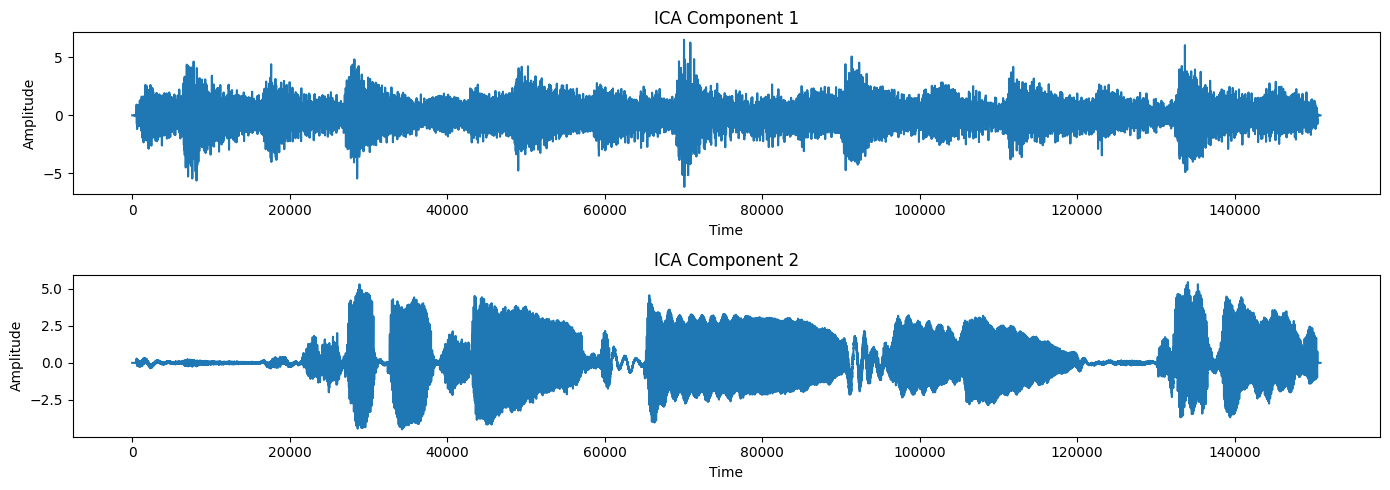

In [101]:
# plot the ICA output
plt.figure(figsize=(14, 5))
for i in range(num_sources):
    plt.subplot(num_sources, 1, i+1)
    plt.plot(ica_output[:, i])
    plt.title('ICA Component ' + str(i+1))
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [102]:
for i in range(num_sources):
    ipd.display(ipd.Audio(ica_output[:, i], rate=sr))
